In [171]:
import numpy as np
import cv2
import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision
import os
import math
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import random
import time
import joblib

## Prepare data

In [172]:
def get_files_in_folder(folder):
      # Liste les fichiers dans le dossier spécifié
      files = [folder  + "/" + f for f in os.listdir(folder) if os.path.isfile(os.path.join(folder, f))]
      return files

In [173]:
def get_coords(point):
  return [point.x, point.y, point.z]

In [174]:
def get_angles(base, finger, hand):
    # Convertir les coordonnées des points en un tableau NumPy pour faciliter les calculs
    points = np.array([[base.x, base.y, base.z]] + [[p.x, p.y, p.z] for p in finger])

    # Initialiser une liste pour stocker les angles
    angles = []

    # Boucler sur les triplets de points
    for i in range(len(points) - 2):
        # Points A, B, C
        A, B, C = points[i], points[i + 1], points[i + 2]

        # Calcul des vecteurs BA et BC
        BA = A - B
        BC = C - B

        # Normalisation des vecteurs
        BA = BA / np.linalg.norm(BA)
        BC = BC / np.linalg.norm(BC)

        # Produit scalaire entre BA et BC
        dot_product = np.dot(BA, BC)

        # Calcul de l'angle en radians
        cos_theta = np.clip(dot_product, -1.0, 1.0)  # S'assurer que cos_theta reste dans [-1, 1]

        # Ajouter l'angle en radians à la liste
        angles.append(np.arccos(cos_theta) / np.pi) # Calcul de l'angle en radian / pi (pour que angle soit dans [0, 1])

        if i != len(points) - 3: # Calculer la rotation entre les plans
          # Points A, B, C, D
          D = points[i + 3]

          # Calcul des vecteurs AB, AC, BC, BD
          AB = B - A
          AC = C - A
          BD = D - B
          CD = D - C

          #  Normalisation des vecteurs
          AB = AB / np.linalg.norm(AB)
          AC = AC / np.linalg.norm(AC)
          BD = BD / np.linalg.norm(BD)
          CD = CD / np.linalg.norm(CD)

          # Calcul des vecteurs normaux au plan ABC  et BCD
          u = np.cross(AB, AC)
          v = np.cross(BD, CD)

          # Calcul de l'angle en radians
          cos_theta = np.dot(u, v) / (np.linalg.norm(u) * np.linalg.norm(v))
          cos_theta = np.clip(cos_theta, -1.0, 1.0)  # S'assurer que cos_theta reste dans [-1, 1]

          # Ajouter l'angle en radians à la liste
          angles.append(np.arccos(cos_theta) / np.pi) # Calcul de l'angle en radian / pi (pour que angle soit dans [0, 1])

    return angles

def signed_distance(point, normal_vector, d, index):
    """
    Calcule la distance signée d'un point par rapport à un plan.
    :param point: Coordonnées du point [x, y, z]
    :param normal_vector: Vecteur normal du plan [a, b, c]
    :param d: Terme constant de l'équation du plan
    :return: Distance signée
    """
    return (np.dot(normal_vector, point) + d) * math.sqrt((index[1].x - index[0].x)**2 + (index[1].y - index[0].y)**2 + (index[1].z - index[0].z)**2) # De la même longueur que la métacarpe de l'index

def projection_point(p1, p2, q):
    """ Calcule la projection du point q sur la droite passant par p1 et p2 """
    v1 = np.array(p1) - np.array(p2)
    v2 = np.array(q) - np.array(p2)
    t = np.dot(v1, v2) / np.dot(v1, v1)
    return np.array(p2) + t * v1

In [175]:
def preprocess(detection):
  hand = detection.handedness[0][0].category_name
  base_poignet = detection.hand_landmarks[0][0]
  pouce = detection.hand_landmarks[0][1:5]
  index = detection.hand_landmarks[0][5:9]
  majeur = detection.hand_landmarks[0][9:13]
  annulaire = detection.hand_landmarks[0][13:17]
  auriculaire = detection.hand_landmarks[0][17:21]

  ## Calcul des angles entre les phalages et la rotation
  angles = get_angles(base_poignet, pouce, hand) + get_angles(base_poignet, index, hand) + get_angles(base_poignet, majeur, hand) + get_angles(base_poignet, annulaire, hand) + get_angles(base_poignet, auriculaire, hand)

  ## Ajout de l'orientation de poignet
  hand_without_fingers = np.array([get_coords(base_poignet), get_coords(pouce[0]), get_coords(index[0]), get_coords(majeur[0]), get_coords(annulaire[0]), get_coords(auriculaire[0])])

  # Appliquer la SVD
  U, S, Vt = np.linalg.svd(hand_without_fingers - np.mean(hand_without_fingers, axis=0))

  # Le vecteur normal du plan est donné par la dernière ligne de Vt
  if np.dot(Vt[2], [1, 1, 1]) >= -np.dot(Vt[2], [1, 1, 1]):
    normal_vector = Vt[2]
  else:
    normal_vector = -Vt[2]

  # Si la paume est vers l'avant de l'écran, c'est à dire le point moyen des bout de doigts est dans la même direction que le vecteur normal
  paume_vers_avant = 0
  if signed_distance(np.mean([get_coords(pouce[-1]), get_coords(index[-1]), get_coords(majeur[-1]), get_coords(annulaire[-1]), get_coords(auriculaire[-1])], axis=0), normal_vector, -np.dot(normal_vector, np.mean(hand_without_fingers, axis=0)), index) > 0:
    normal_vector = -normal_vector
    paume_vers_avant = 1

  # Normalisation du vecteur normal
  normal_vector = normal_vector / np.linalg.norm(normal_vector)

  ### L'index et le majeur sont croisés (pour différencier le R du U)

  # Equation du plan moyen
  a, b, c = normal_vector
  d = -np.dot(normal_vector, np.mean(hand_without_fingers, axis=0))

  ## Calcul de la distance signé entre le plan et l'index et le majeur * la distance de la métacarpe de l'index
  majeur_sur_index = signed_distance(get_coords(majeur[-1]), normal_vector, d, index) - signed_distance(get_coords(index[-1]), normal_vector, d, index)

  ## Calcul de la distance entre les points projetés de la dernière phalange de l'index et du majeur sur la droite donnée par les premières phalanges de l'index et du majeur divisé par la distance entre la première distance de l'index et du majeur

  # Projections des derniers points de l'index et du majeur sur la droite
  index_proj = np.array(projection_point(get_coords(index[0]), get_coords(index[1]), get_coords(index[-1])))
  majeur_proj = np.array(projection_point(get_coords(majeur[0]), get_coords(majeur[1]), get_coords(majeur[-1])))

  # Distance entre les projections des derniers points de l'index et du majeur
  distance_proj = np.linalg.norm(index_proj - majeur_proj)

  # Distance entre les premières phalanges de l'index et du majeur
  distance_base = np.linalg.norm(np.array(get_coords(index[0])) - np.array(get_coords(majeur[0])))

  # Calcul final
  ratio = -distance_proj / distance_base

  # Detection de si le pouce est devant l'index (pour le F et le T)
  index_base_proj_ind_aur = projection_point(get_coords(index[0]), get_coords(auriculaire[0]), get_coords(index[0]))
  index_proj_ind_aur = projection_point(get_coords(index[0]), get_coords(auriculaire[0]), get_coords(index[-1]))
  pouce_proj_ind_aur = projection_point(get_coords(index[0]), get_coords(auriculaire[0]), get_coords(pouce[-1]))
  pouce_ind_croise = int(np.linalg.norm(index_base_proj_ind_aur - index_proj_ind_aur) > np.linalg.norm(index_base_proj_ind_aur - pouce_proj_ind_aur)) # 1 si croise, 0 sinon

  ## Calculer l'angle entre l'index et le majeur

  # Convertir les points en numpy arrays

  # Calcul des vecteurs AB et CD
  index_top_bottom = np.array(get_coords(index[-1])) - np.array(get_coords(index[0]))
  majeur_top_bottom = np.array(get_coords(majeur[-1])) - np.array(get_coords(majeur[0]))

  # Produit scalaire des deux vecteurs
  dot_product = np.dot(index_top_bottom, majeur_top_bottom)

  # Cosinus de l'angle
  cos_theta = dot_product / (np.linalg.norm(index_top_bottom) * np.linalg.norm(majeur_top_bottom))

  # Angle en radians
  angle_index_majeur = np.arccos(np.clip(cos_theta, -1.0, 1.0)) / np.pi  # Clip pour éviter les erreurs numériques

  return angles + [paume_vers_avant, majeur_sur_index, ratio, pouce_ind_croise, angle_index_majeur]

In [176]:
def test_models(X_train_act, X_test_act):
  best_model  = None
  best_score = 0
  print("KNN :\n")
  scores = []
  for i in range(1, 12):
    knn = KNeighborsClassifier(n_neighbors = i)
    knn.fit(X_train_act, y_train_detected)
    score = knn.score(X_test_act, y_test_detected)
    scores.append(score)
    if score > best_score:
      best_score = score
      best_model = knn
  print(np.mean(scores), np.min(scores), np.max(scores), np.argmax(scores))

  print("\nDecision Tree :\n")
  scores = []
  for i in range(100):
    dt = DecisionTreeClassifier(random_state=i)
    dt.fit(X_train_act, y_train_detected)
    score = dt.score(X_test_act, y_test_detected)
    scores.append(score)
    if score > best_score:
      best_score = score
      best_model = dt
  print(np.mean(scores), np.min(scores), np.max(scores), np.argmax(scores))

  print("\nSVC :\n")
  svc = SVC()
  svc.fit(X_train_act, y_train_detected)
  score = svc.score(X_test_act, y_test_detected)
  print(score)
  if score > best_score:
    best_score = score
    best_model = svc

  print("\nRandom Forest :\n")
  scores = []
  for i in range(100):
    rf = RandomForestClassifier(random_state=i)
    rf.fit(X_train_act, y_train_detected)
    score = rf.score(X_test_act, y_test_detected)
    scores.append(score)
    if score > best_score:
      best_score = score
      best_model = rf
  print(np.mean(scores), np.min(scores), np.max(scores), np.argmax(scores))

  print("\nLogistic Regression :\n")
  lr = LogisticRegression()
  lr.fit(X_train_act, y_train_detected)
  score = lr.score(X_test_act, y_test_detected)
  print(score)
  if score > best_score:
    best_score = score
    best_model = lr

  return best_model

def draw_conf_matrix(best_model, X_test_act):
  # Prédictions
  y_pred = best_model.predict(X_test_act)

  # Calcul de la matrice de confusion
  cm = confusion_matrix(y_test_detected, y_pred)

  # Définir de nouvelles étiquettes (A, B, C, etc.)
  num_classes = len(np.unique(y_test_detected))
  labels = [chr(65 + i) for i in range(num_classes)]  # Génère A, B, C, ...

  # Affichage de la matrice de confusion avec les nouvelles étiquettes
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
  disp.plot(cmap="Blues")

  # Afficher le graphique
  plt.show()

In [177]:
# STEP 1:  Get files path
train = get_files_in_folder("train")
test = get_files_in_folder("test")

# STEP 2: Create an HandLandmarker object.
base_options = python.BaseOptions(model_asset_path='hand_landmarker.task')
options = vision.HandLandmarkerOptions(base_options=base_options,
                                       num_hands=1)
detector = vision.HandLandmarker.create_from_options(options)

# STEP 3:  Create X_train, X_test, y_train, y_test
X_train =  [cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB) for image_path in train]
y_train = [ord(image_path[-5]) - 65  for image_path in train]
X_test =  [cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB) for image_path in test]
y_test = [ord(image_path[-5]) - 65  for image_path in test]

# STEP 4: Predict with mediapipe
X_train_detected,  y_train_detected =  [], []
X_test_detected,  y_test_detected =  [], []

for i in range(0, len(X_train)):
    detection = detector.detect(mp.Image(image_format=mp.ImageFormat.SRGB, data=X_train[i]))
    if len(detection.handedness) > 0:
        if detection.handedness[0][0].category_name == "Left":
          for j in range(0, len(detection.hand_landmarks[0])):
            detection.hand_landmarks[0][j].x = 1 - detection.hand_landmarks[0][j].x
        X_train_detected.append(detection)
        y_train_detected.append(y_train[i])

for i in range(0, len(X_test)):
    detection = detector.detect(mp.Image(image_format=mp.ImageFormat.SRGB, data=X_test[i]))
    if len(detection.handedness) > 0:
        if detection.handedness[0][0].category_name == "Left":
          for j in range(0, len(detection.hand_landmarks[0])):
            detection.hand_landmarks[0][j].x = 1 - detection.hand_landmarks[0][j].x
        X_test_detected.append(detection)
        y_test_detected.append(y_test[i])

# STEP 5: preprocess and stardardize data and reverse data for model 1 and 2
X_train_1_preprocessed = [preprocess(detection) for detection in X_train_detected]
X_test_1_preprocessed = [preprocess(detection) for detection in X_test_detected]

scaler_1  = StandardScaler()
scaler_1.fit(X_train_1_preprocessed)

X_train_1 = scaler_1.transform(X_train_1_preprocessed)
X_test_1 = scaler_1.transform(X_test_1_preprocessed)

X_train_2_preprocessed = [np.array([[lm.x, lm.y, lm.z] for lm in detection.hand_landmarks[0]]).flatten() for detection in X_train_detected]
X_test_2_preprocessed = [np.array([[lm.x, lm.y, lm.z] for lm in detection.hand_landmarks[0]]).flatten() for detection in X_test_detected]

scaler_2  = StandardScaler()
scaler_2.fit(X_train_2_preprocessed)

X_train_2 = scaler_2.transform(X_train_2_preprocessed)
X_test_2 = scaler_2.transform(X_test_2_preprocessed)


# First approch

In [178]:
best_model_1 = test_models(X_train_1, X_test_1)

KNN :

0.8025974025974025 0.7285714285714285 0.8285714285714286 6

Decision Tree :

0.7165714285714286 0.6571428571428571 0.7714285714285715 65

SVC :

0.8428571428571429

Random Forest :

0.8820000000000001 0.8285714285714286 0.9428571428571428 90

Logistic Regression :

0.8714285714285714


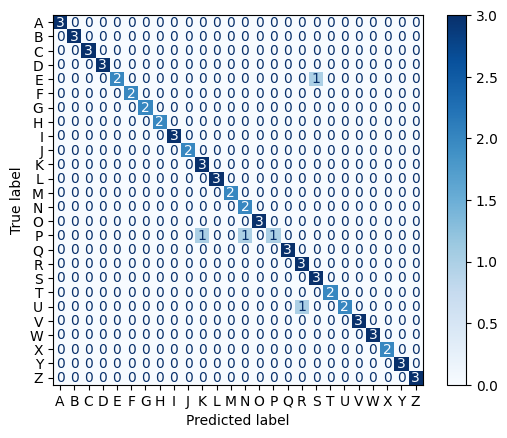

In [179]:
draw_conf_matrix(best_model_1, X_test_1)

In [180]:
%timeit best_model_1.predict(X_test_1)

3.06 ms ± 20.9 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


# Second approch

In [181]:
best_model_2 = test_models(X_train_2, X_test_2)

KNN :

0.41298701298701307 0.35714285714285715 0.4714285714285714 8

Decision Tree :

0.3791428571428571 0.32857142857142857 0.44285714285714284 1

SVC :

0.5

Random Forest :

0.5367142857142856 0.45714285714285713 0.6428571428571429 47

Logistic Regression :

0.8857142857142857


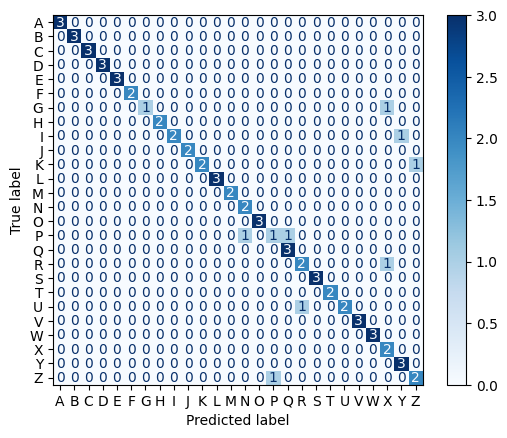

In [182]:
draw_conf_matrix(best_model_2, X_test_2)

In [183]:
%timeit best_model_2.predict(X_test_2)

69.2 μs ± 240 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


# Combine models

In [184]:
y_pred_1 = best_model_1.predict_proba(X_train_1)
y_pred_2 = best_model_2.predict_proba(X_train_2)
X_train_3 = np.concatenate((y_pred_1, y_pred_2), axis=1)

y_pred_1_test = best_model_1.predict_proba(X_test_1)
y_pred_2_test = best_model_2.predict_proba(X_test_2)
X_test_3 = np.concatenate((y_pred_1_test, y_pred_2_test), axis=1)

In [185]:
best_model_3 = test_models(X_train_3, X_test_3)

KNN :

0.9350649350649352 0.9285714285714286 0.9571428571428572 5

Decision Tree :

0.7919999999999999 0.7285714285714285 0.8571428571428571 57

SVC :

0.9714285714285714

Random Forest :

0.9127142857142857 0.9 0.9285714285714286 23

Logistic Regression :

0.9571428571428572


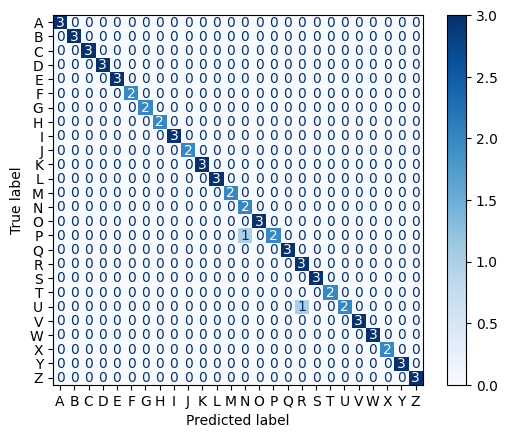

In [186]:
draw_conf_matrix(best_model_3, X_test_3)

In [187]:
%timeit best_model_3.predict(X_test_3)

998 μs ± 6.43 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


# Save models

In [188]:
joblib.dump(scaler_1, "scaler_1.pkl", compress=0)
joblib.dump(scaler_2, "scaler_2.pkl", compress=0)
joblib.dump(best_model_1, "best_model_1.pkl", compress=0)
joblib.dump(best_model_2, "best_model_2.pkl", compress=0)
joblib.dump(best_model_3, 'best_model_3.pkl', compress=0)

['best_model_3.pkl']

# Test pipeline

In [213]:
def pipeline_predict(img):
    detection = detector.detect(mp.Image(image_format=mp.ImageFormat.SRGB, data=img))
    if len(detection.handedness) == 0:
      return None

    if detection.handedness[0][0].category_name == "Left":
      for j in range(0, len(detection.hand_landmarks[0])):
        detection.hand_landmarks[0][j].x = 1 - detection.hand_landmarks[0][j].x

    preprocessed = preprocess(detection)

    data_model_1 = scaler_1.transform([preprocessed])
    y_pred_1 = best_model_1.predict_proba(data_model_1)
    entropy_1 = -np.sum(np.clip(y_pred_1[0], 1e-10, 1) * np.log(np.clip(y_pred_1[0], 1e-10, 1))) / math.log(len(y_pred_1[0]))
    if entropy_1 > 0.8:
       return None
    
    data_model_2 = scaler_2.transform([np.array([[lm.x, lm.y, lm.z] for lm in detection.hand_landmarks[0]]).flatten()])
    y_pred_2 = best_model_2.predict_proba(data_model_2)
    entropy_2 = -np.sum(np.clip(y_pred_2[0], 1e-10, 1) * np.log(np.clip(y_pred_2[0], 1e-10, 1))) / math.log(len(y_pred_2[0]))
    if  entropy_2 > 0.9:
       return None

    data_model_3 = np.concatenate((y_pred_1, y_pred_2), axis=1)
    return best_model_3.predict(data_model_3)[0]

In [214]:
img_path = random.choice(test)
img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
pred = pipeline_predict(img)

print("Prediction :", chr(65 + pred), ", Réalité :", img_path[-5], ", Hauteur de l'image :", img.shape[0], ", Largeur de l'image :", img.shape[1])

%timeit pipeline_predict(img)

Prediction : H , Réalité : H , Hauteur de l'image : 746 , Largeur de l'image : 940
30.5 ms ± 1.17 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [216]:
# Compute average speed by pixels
times, pixels = [], []
for img_path in train + test:
  img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
  time_start = time.time()
  pred = pipeline_predict(img)
  time_end = time.time()
  times.append((time_end - time_start) * 1000)
  pixels.append(img.shape[0] * img.shape[1])

lr = LinearRegression()
lr.fit(np.array([pixels]).T, np.array(times))
print("time (ms) =", lr.coef_[0], "x Nombre de pixels de l'image +", lr.intercept_)

time (ms) = 2.6657158340988354e-06 x Nombre de pixels de l'image + 29.741259547663404


In [217]:
print("Ainsi pour une webcam en HD (1280 x 720 pixels), prédire une image prendrait environ :", lr.predict([[1280 * 720]])[0], "ms")

Ainsi pour une webcam en HD (1280 x 720 pixels), prédire une image prendrait environ : 32.19798326036889 ms
